In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
import mlflow
import mlflow.sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from imblearn.combine import SMOTETomek
import tensorflow as tf
from tensorflow.keras import layers, models

# Load Data

In [2]:
df = pd.read_csv("C:/Users/Harish/Desktop/GUVI/FinalProject_2/Data/fraud_dataset.csv")

In [3]:
df.head()

,claim_id,cust_id,policy_date,claim_date,claim_amount,income,claim_type,suspicious_flag,fraud_label
0,CLM_82344a57-5,CUST_024586e6,8/7/2024,10/29/2024,2684.43,55107.52,Theft,1,0
1,CLM_430c9691-b,CUST_2d8b4014,2/3/2022,3/4/2024,6159.45,72499.96,Personal Injury,0,0
2,CLM_2f7b6081-f,CUST_b0b93bad,1/27/2024,4/10/2024,9299.43,94888.79,Property Damage,1,1
3,CLM_e284e732-b,CUST_825e5547,10/18/2021,9/28/2023,26630.52,43691.03,Natural Disaster,0,0
4,CLM_88cd42bc-7,CUST_de61c4a3,4/13/2022,7/13/2024,15408.13,18996.91,Medical,0,0


In [4]:
df.isna().sum()

claim_id           0
cust_id            0
policy_date        0
claim_date         0
claim_amount       0
income             0
claim_type         0
suspicious_flag    0
fraud_label        0
dtype: int64

In [5]:
df.shape

(10000, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   claim_id         10000 non-null  object 
 1   cust_id          10000 non-null  object 
 2   policy_date      10000 non-null  object 
 3   claim_date       10000 non-null  object 
 4   claim_amount     10000 non-null  float64
 5   income           10000 non-null  float64
 6   claim_type       10000 non-null  object 
 7   suspicious_flag  10000 non-null  int64  
 8   fraud_label      10000 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 703.3+ KB


In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
df.columns

Index(['claim_id', 'cust_id', 'policy_date', 'claim_date', 'claim_amount',
       'income', 'claim_type', 'suspicious_flag', 'fraud_label'],
      dtype='object')

# Explorartory Data Analysis

### Data Visualization: 1. Claim Amount Vs Claim Type

In [9]:
df.claim_type.value_counts()

claim_type
Personal Injury          1055
Property Damage          1051
Medical                  1040
Fire                     1034
Theft                    1010
Travel                    986
Natural Disaster          980
Liability                 978
Auto Collision            965
Business Interruption     901
Name: count, dtype: int64

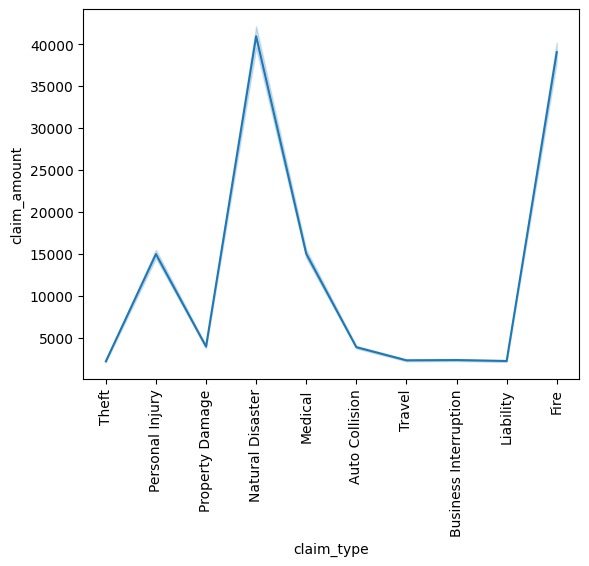

In [10]:
sns.lineplot(x=df["claim_type"], y=df["claim_amount"])
plt.xticks(rotation=90)
plt.show()

### 2. Claim Amount vs. Income (with Claim Type Hue)

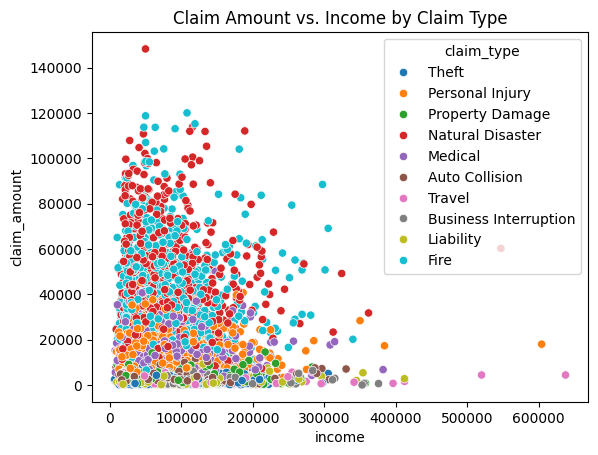

In [11]:
sns.scatterplot(x='income', y='claim_amount', hue='claim_type', data=df)
plt.title("Claim Amount vs. Income by Claim Type")
plt.show()

### 3. Claim Amount Over Time

In [12]:
df['claim_date'] = pd.to_datetime(df['claim_date'], errors='coerce')
df['policy_date'] = pd.to_datetime(df['policy_date'], errors='coerce')

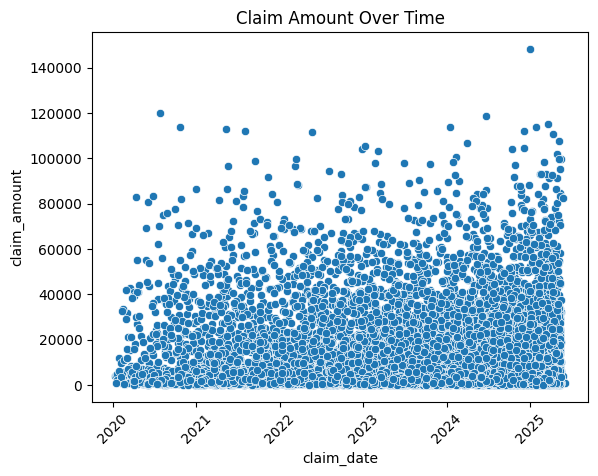

In [13]:
sns.scatterplot(x='claim_date', y='claim_amount', data=df)
plt.title("Claim Amount Over Time")
plt.xticks(rotation=45)
plt.show()

### 4. Number of Claims by Claim Type

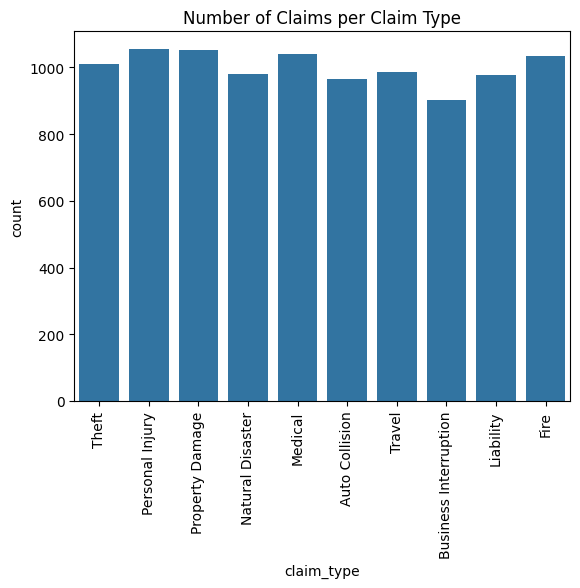

In [14]:
sns.countplot(x='claim_type', data=df)
plt.title("Number of Claims per Claim Type")
plt.xticks(rotation=90)
plt.show()

### 5. Fraud Label Distribution

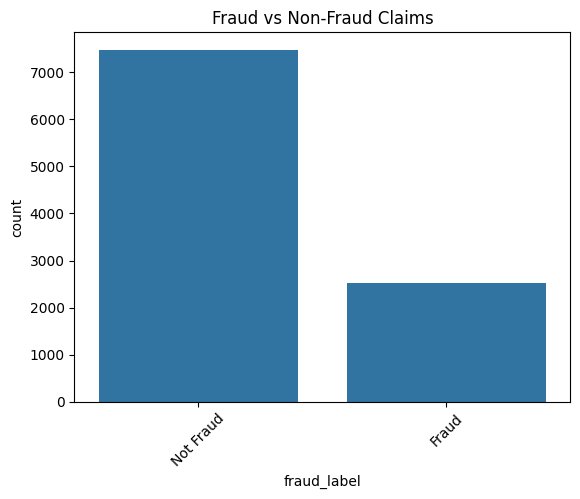

In [15]:
sns.countplot(x='fraud_label', data=df)
plt.title("Fraud vs Non-Fraud Claims")
plt.xticks([0,1], ['Not Fraud', 'Fraud'])
plt.xticks(rotation=45)
plt.show()

### 6. Suspicious Flag vs Claim Type

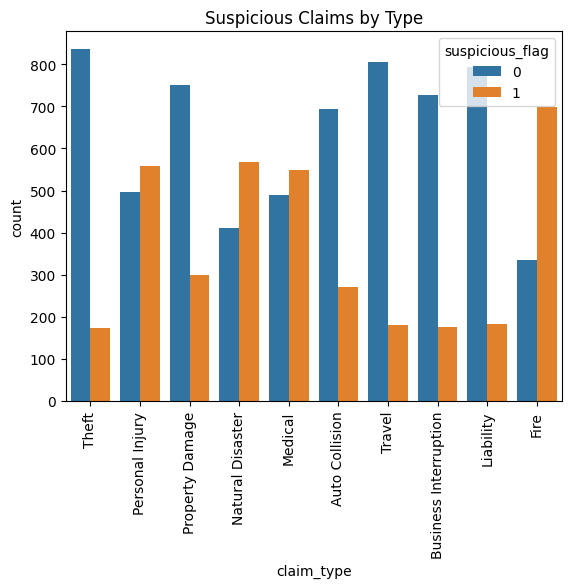

In [16]:
sns.countplot(x='claim_type', hue='suspicious_flag', data=df)
plt.title("Suspicious Claims by Type")
plt.xticks(rotation=90)
plt.show()

### Boxplot to compare claim distributions across different insurance types.

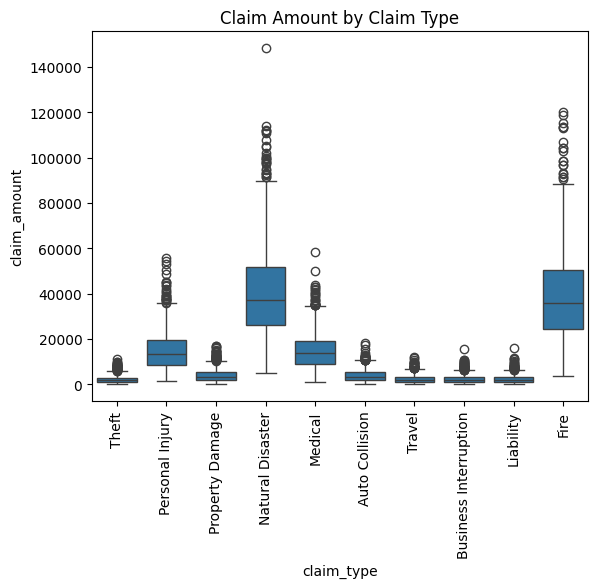

In [17]:
sns.boxplot(x='claim_type', y='claim_amount', data=df)
plt.title("Claim Amount by Claim Type")
plt.xticks(rotation=90)
plt.show()

# Feature Engineering

### Identify claims filed within an unusually short period after policy issuance.

In [18]:
df['claim_processing_days'] = (df['claim_date'] - df['policy_date']).dt.days
df['claim_processing_days']

0        83
1       760
2        74
3       710
4       822
       ... 
9995    759
9996    177
9997    173
9998    480
9999    317
Name: claim_processing_days, Length: 10000, dtype: int64

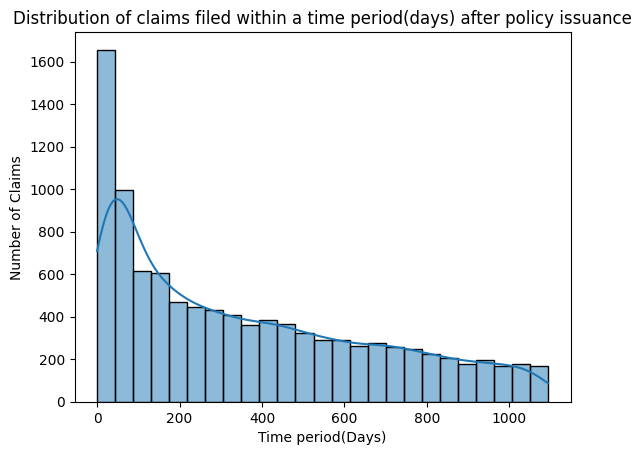

In [19]:
sns.histplot(df['claim_processing_days'], bins=25, kde=True)
plt.title("Distribution of claims filed within a time period(days) after policy issuance")
plt.xlabel("Time period(Days)")
plt.ylabel("Number of Claims")
plt.show()

# Approximately 2500 claims have been registered under 100 days of policy issue date.

### Generate Claim-to-Income Ratio (Claim_Amount / Annual_Income) as a new feature.

In [20]:
df['claim_to_income_ratio'] = df['claim_amount']*100 / df['income']

In [21]:
df.head(3)

,claim_id,cust_id,policy_date,claim_date,claim_amount,income,claim_type,suspicious_flag,fraud_label,claim_processing_days,claim_to_income_ratio
0,CLM_82344a57-5,CUST_024586e6,2024-08-07,2024-10-29,2684.43,55107.52,Theft,1,0,83,4.871259
1,CLM_430c9691-b,CUST_2d8b4014,2022-02-03,2024-03-04,6159.45,72499.96,Personal Injury,0,0,760,8.495798
2,CLM_2f7b6081-f,CUST_b0b93bad,2024-01-27,2024-04-10,9299.43,94888.79,Property Damage,1,1,74,9.800346


In [22]:
df[~np.isfinite(df['claim_to_income_ratio'])]

,claim_id,cust_id,policy_date,claim_date,claim_amount,income,claim_type,suspicious_flag,fraud_label,claim_processing_days,claim_to_income_ratio


In [23]:
df = df[np.isfinite(df['claim_to_income_ratio'])]

In [24]:
df[~np.isfinite(df['claim_to_income_ratio'])]

,claim_id,cust_id,policy_date,claim_date,claim_amount,income,claim_type,suspicious_flag,fraud_label,claim_processing_days,claim_to_income_ratio


# Outlier Removal & Anomaly Detection

In [25]:
"""
🔹 1. Select Features for Anomaly Detection
🔹 2. Scale the Features
🔹 3. Apply the Outlier Detection Models
"""

'\n🔹 1. Select Features for Anomaly Detection\n🔹 2. Scale the Features\n🔹 3. Apply the Outlier Detection Models\n'

In [26]:
features = ['claim_amount', 'income', 'claim_processing_days','claim_to_income_ratio']
df_anomaly = df[features].copy()

In [27]:
df_anomaly.head()

,claim_amount,income,claim_processing_days,claim_to_income_ratio
0,2684.43,55107.52,83,4.871259
1,6159.45,72499.96,760,8.495798
2,9299.43,94888.79,74,9.800346
3,26630.52,43691.03,710,60.951916
4,15408.13,18996.91,822,81.108612


In [28]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_anomaly[features])

### Elliptic Envelope

In [29]:
from sklearn.covariance import EllipticEnvelope

ee = EllipticEnvelope(contamination=0.05)
df_anomaly['elliptic_outlier'] = ee.fit_predict(X_scaled)  # -1 = outlier, 1 = inlier

### Isolation Forest

In [30]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.05, random_state=42)
df_anomaly['iso_outlier'] = iso.fit_predict(X_scaled)

### Local Outlier Factor

In [31]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
df_anomaly['lof_outlier'] = lof.fit_predict(X_scaled)

### Interpret Results

In [32]:
# Count how many times each point was flagged as an outlier
df_anomaly['outlier_votes'] = (df_anomaly[['elliptic_outlier', 'iso_outlier', 'lof_outlier']] == -1).sum(axis=1)

# Tag as suspicious if flagged by 2 or more models
df_anomaly['suspicious_flag'] = (df_anomaly['outlier_votes'] >= 2).astype(int)

In [33]:
df_anomaly.suspicious_flag.value_counts()

suspicious_flag
0    9605
1     395
Name: count, dtype: int64

In [34]:
df.suspicious_flag.value_counts()

suspicious_flag
0    6341
1    3659
Name: count, dtype: int64

In [36]:
df['anomaly_suspicious_flag'] = df_anomaly['suspicious_flag']

In [37]:
df.head(1)

,claim_id,cust_id,policy_date,claim_date,claim_amount,income,claim_type,suspicious_flag,fraud_label,claim_processing_days,claim_to_income_ratio,anomaly_suspicious_flag
0,CLM_82344a57-5,CUST_024586e6,2024-08-07,2024-10-29,2684.43,55107.52,Theft,1,0,83,4.871259,0


# Data Preparation:
1. Drop ID and Date Columns and
2. apply OHE on claim_type

In [38]:
df_train = df.drop(columns=['claim_id','cust_id','policy_date','claim_date'], axis=1)

In [39]:
df_train = pd.get_dummies(df_train,columns=['claim_type'], drop_first=True, dtype=int)

In [40]:
df_train.head()

,claim_amount,income,suspicious_flag,fraud_label,claim_processing_days,claim_to_income_ratio,anomaly_suspicious_flag,claim_type_Business Interruption,claim_type_Fire,claim_type_Liability,claim_type_Medical,claim_type_Natural Disaster,claim_type_Personal Injury,claim_type_Property Damage,claim_type_Theft,claim_type_Travel
0,2684.43,55107.52,1,0,83,4.871259,0,0,0,0,0,0,0,0,1,0
1,6159.45,72499.96,0,0,760,8.495798,0,0,0,0,0,0,1,0,0,0
2,9299.43,94888.79,1,1,74,9.800346,0,0,0,0,0,0,0,1,0,0
3,26630.52,43691.03,0,0,710,60.951916,0,0,0,0,0,1,0,0,0,0
4,15408.13,18996.91,0,0,822,81.108612,0,0,0,0,1,0,0,0,0,0


In [41]:
df_train.columns

Index(['claim_amount', 'income', 'suspicious_flag', 'fraud_label',
       'claim_processing_days', 'claim_to_income_ratio',
       'anomaly_suspicious_flag', 'claim_type_Business Interruption',
       'claim_type_Fire', 'claim_type_Liability', 'claim_type_Medical',
       'claim_type_Natural Disaster', 'claim_type_Personal Injury',
       'claim_type_Property Damage', 'claim_type_Theft', 'claim_type_Travel'],
      dtype='object')

### Correlation

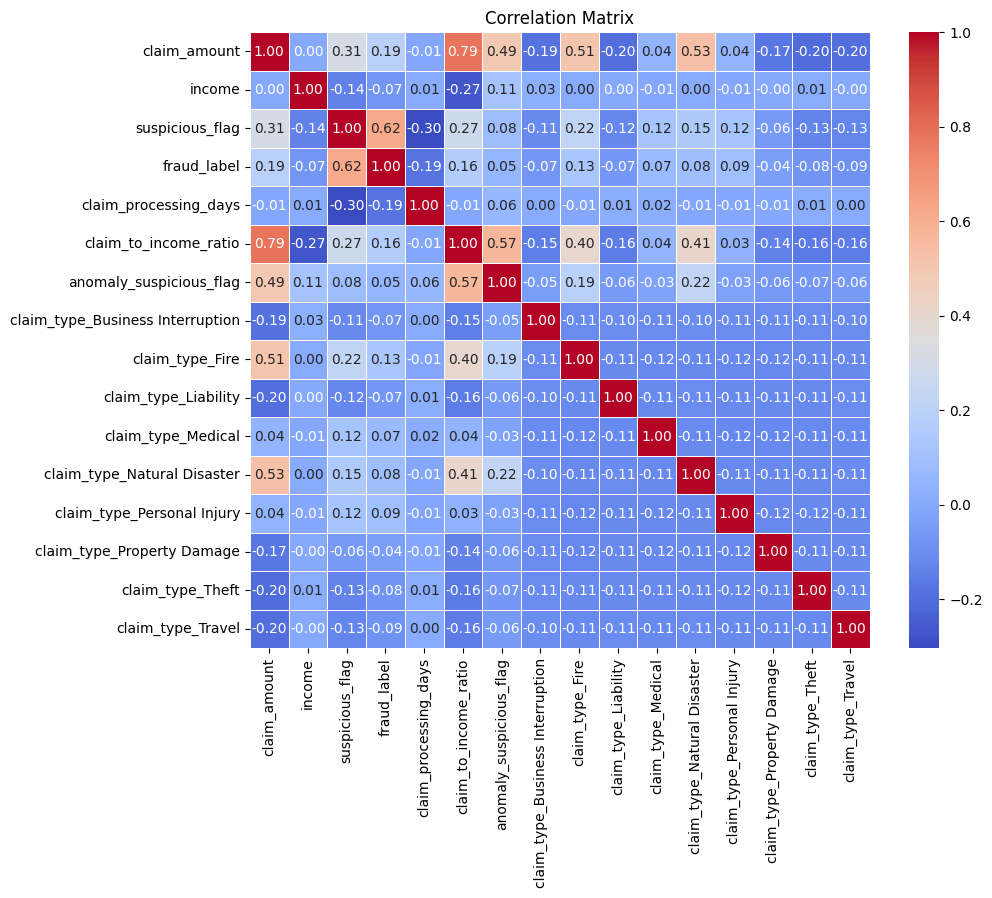

In [42]:
# Compute correlation matrix
corr_matrix = df_train.corr()

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Model Training

### Prepate the date
1. Use StandardScaler
2. Create X and y dataset

In [43]:
scaler = StandardScaler()
cols_to_scale = ['claim_amount', 'income', 'claim_processing_days','claim_to_income_ratio']
df_train[cols_to_scale] = scaler.fit_transform(df_train[cols_to_scale])
df_train.describe()

,claim_amount,income,suspicious_flag,fraud_label,claim_processing_days,claim_to_income_ratio,anomaly_suspicious_flag,claim_type_Business Interruption,claim_type_Fire,claim_type_Liability,claim_type_Medical,claim_type_Natural Disaster,claim_type_Personal Injury,claim_type_Property Damage,claim_type_Theft,claim_type_Travel
count,1.000000e+04,1.000000e+04,10000.000000,10000.000000,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,-2.842171e-18,-2.813749e-16,0.365900,0.252500,4.227729e-17,3.979039e-17,0.039500,0.090100,0.103400,0.097800,0.104000,0.09800,0.105500,0.105100,0.101000,0.098600
std,1.000050e+00,1.000050e+00,0.481706,0.434468,1.000050e+00,1.000050e+00,0.194791,0.286339,0.304496,0.297059,0.305276,0.29733,0.307212,0.306698,0.301344,0.298139
min,-7.327660e-01,-1.392723e+00,0.000000,0.000000,-1.164456e+00,-5.805863e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,-6.290282e-01,-6.787606e-01,0.000000,0.000000,-9.172301e-01,-5.183230e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,-4.619838e-01,-2.573137e-01,0.000000,0.000000,-2.558206e-01,-3.924020e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,2.632889e-01,4.057477e-01,1.000000,1.000000,7.395042e-01,8.317794e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,7.717216e+00,1.204885e+01,1.000000,1.000000,2.348078e+00,1.427133e+01,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


### Train Test Split

In [44]:
X = df_train.drop(columns=['fraud_label'],axis=1)
y = df_train['fraud_label']

In [45]:
y.value_counts()

fraud_label
0    7475
1    2525
Name: count, dtype: int64

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.30, random_state=42,stratify=y)

### Class Imbalance
1. Use SMOTE technique to handle class imbalance
2. Parameter tuning using RandomizedSearchCV

In [47]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(random_state=42)
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)
print(y_train_smt.value_counts())

fraud_label
0    4924
1    4924
Name: count, dtype: int64


# Model Training and Evaluation - Random Forest classifier

In [48]:
model = RandomForestClassifier()
model.fit(X_train_smt, y_train_smt)

y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.83      0.87      2243
           1       0.61      0.79      0.69       757

    accuracy                           0.82      3000
   macro avg       0.77      0.81      0.78      3000
weighted avg       0.84      0.82      0.83      3000



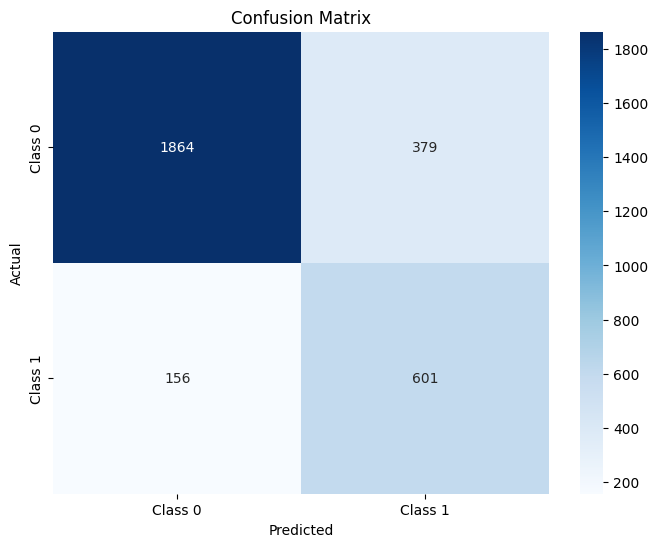

In [49]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
xticklabels=['Class 0', 'Class 1'],
yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Model Training and Evaluation - Feed Forward Neural Network

In [62]:
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_smt.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.005)  # Try lower or higher
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['AUC'])

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\Harish\anaconda3\envs\NLP\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [63]:
history = model.fit(X_train_smt, y_train_smt, validation_split=0.2, epochs=30, batch_size=32)

Epoch 1/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8128 - loss: 0.5031 - val_AUC: 0.0000e+00 - val_loss: 0.5751
Epoch 2/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8700 - loss: 0.3987 - val_AUC: 0.0000e+00 - val_loss: 0.5302
Epoch 3/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8768 - loss: 0.3888 - val_AUC: 0.0000e+00 - val_loss: 0.6013
Epoch 4/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8773 - loss: 0.3831 - val_AUC: 0.0000e+00 - val_loss: 0.5479
Epoch 5/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8772 - loss: 0.3939 - val_AUC: 0.0000e+00 - val_loss: 0.6176
Epoch 6/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8778 - loss: 0.3845 - val_AUC: 0.0000e+00 - val_loss: 0.5640
Epoch 7/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8808 - loss: 0.3800 - val_AUC: 0.0000e+00 - val_loss: 0.5718
Epoch 8/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8805 - loss: 0.3833 - val_AUC: 0.0000e+00 - val_loss: 0.4939
Epoch 9/30
247/247 ━━━━━

In [64]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              precision    recall  f1-score   support

           0       0.95      0.82      0.88      2243
           1       0.62      0.87      0.73       757

    accuracy                           0.83      3000
   macro avg       0.79      0.85      0.80      3000
weighted avg       0.87      0.83      0.84      3000



In [73]:
# Make predictions with your model
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


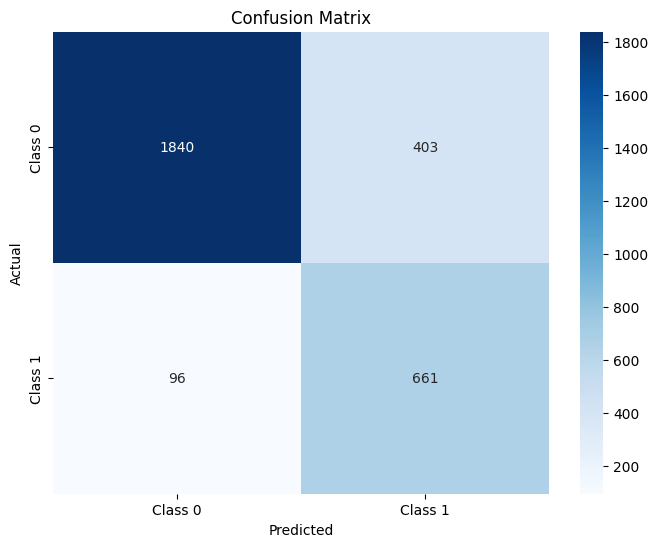

In [65]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
xticklabels=['Class 0', 'Class 1'],
yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Feature Importance - SHAP
SHAP assigns each feature an importance value for a particular prediction based on Shapley values from cooperative game theory.

In [54]:
type(X_train)

pandas.core.frame.DataFrame

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

C:\Users\Harish\anaconda3\envs\NLP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step  


 10%|█         | 1/10 [00:10<01:32, 10.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 20%|██        | 2/10 [00:19<01:18,  9.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 30%|███       | 3/10 [00:29<01:08,  9.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step  


 40%|████      | 4/10 [00:38<00:56,  9.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 50%|█████     | 5/10 [00:47<00:47,  9.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 60%|██████    | 6/10 [00:57<00:37,  9.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 70%|███████   | 7/10 [01:05<00:27,  9.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 80%|████████  | 8/10 [01:15<00:18,  9.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 90%|█████████ | 9/10 [01:24<00:09,  9.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


100%|██████████| 10/10 [01:33<00:00,  9.34s/it]


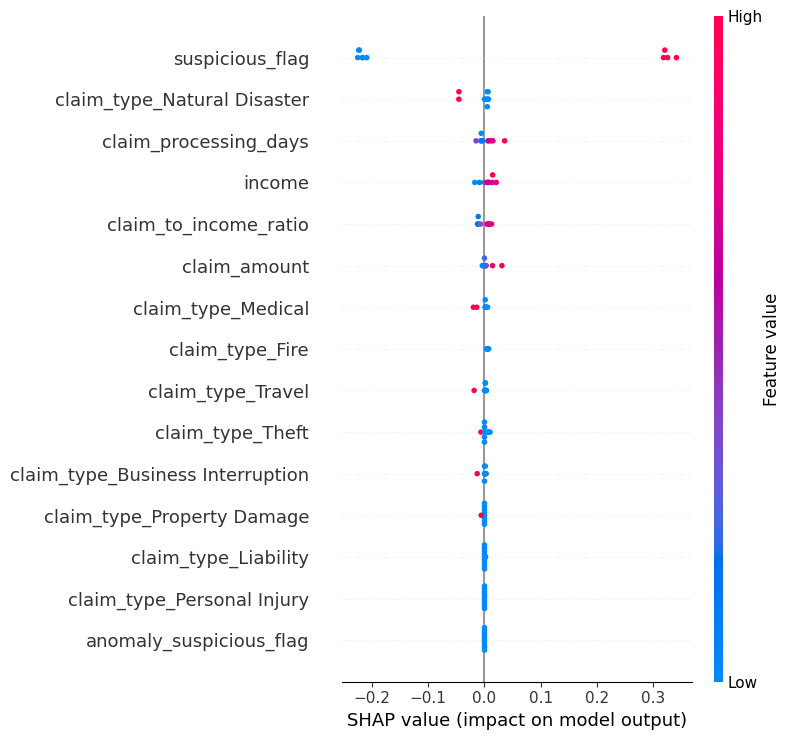

In [55]:
import shap
import numpy as np

# Define a prediction function (returns 1D array of outputs)
f = lambda x: model.predict(x).flatten()

feature_names = X_train.columns.tolist()

# Use a representative background dataset
X_train_scaled = X_train.to_numpy()
background = X_train_scaled[np.random.choice(X_train_scaled.shape[0], 100, replace=False)]

# Initialize KernelExplainer
explainer = shap.KernelExplainer(f, background)

# Compute SHAP values for 10 test samples
X_test_scaled = X_test.to_numpy()
shap_values = explainer.shap_values(X_test_scaled[:10])

# Plot summary
shap.summary_plot(shap_values, X_test_scaled[:10], feature_names=feature_names)

# Export FFNN Model

In [69]:
from joblib import dump

# 1. Save Keras model separately
model.save("C:/Users/Harish/Desktop/GUVI/FinalProject_2/artifacts/anomaly_fraud/model_fraud_data.h5")

# 2. Save metadata (scaler, columns, etc.)
model_metadata = {
    'scaler': scaler,
    'cols_to_scale': cols_to_scale
}
dump(model_metadata, 'C:/Users/Harish/Desktop/GUVI/FinalProject_2/artifacts/anomaly_fraud/model_metadata.joblib')

# 3. Save anamoly detection methods:
dump(lof, 'C:/Users/Harish/Desktop/GUVI/FinalProject_2/artifacts/anomaly_fraud/lof_model.pkl')
dump(ee, 'C:/Users/Harish/Desktop/GUVI/FinalProject_2/artifacts/anomaly_fraud/elliptic_model.pkl')
dump(iso, 'C:/Users/Harish/Desktop/GUVI/FinalProject_2/artifacts/anomaly_fraud/iso_model.pkl')

['C:/Users/Harish/Desktop/GUVI/FinalProject_2/artifacts/anomaly_fraud/iso_model.pkl']

# MLFlow

In [70]:
import mlflow.keras
import mlflow.tensorflow

In [74]:
mlflow.set_experiment("Insurance_Fraud_Anomaly_detection")
mlflow.set_tracking_uri("http://localhost:5000")

# Start MLflow run
with mlflow.start_run(run_name="FFNN_Fraud_Anomaly_Detection") as run:

    # Log parameters manually (optional)
    mlflow.log_param("epochs", 30)
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("learning_rate", 0.005)

    # Log metrics
    mlflow.log_metrics({
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "roc_auc": roc_auc
    })

    model.save("fraud_detection_model.keras")
    mlflow.keras.log_model(model, "model")
    print(f"Run ID: {run.info.run_id}")

2025/06/07 16:48:59 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/06/07 16:49:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run ID: 24b41b3978ef46d8a3e2a0967767bef2
🏃 View run FFNN_Fraud_Anomaly_Detection at: http://localhost:5000/#/experiments/680983656187538068/runs/24b41b3978ef46d8a3e2a0967767bef2
🧪 View experiment at: http://localhost:5000/#/experiments/680983656187538068
